In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

pd.options.display.max_rows = 8  
%matplotlib inline

读取数据

In [2]:
national_debt = pd.read_csv('data/shibor_nation_debt.csv',header=0,index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()
national_debt.describe()

,开盘,收盘,高,低,涨跌幅,on
日期,,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078,2.014
2016/1/22,2.705,2.689,2.705,2.682,-0.0041,2.028
2016/1/25,2.750,2.694,2.750,2.680,0.0019,2.009
2016/1/26,2.703,2.738,2.740,2.690,0.0163,1.997
2016/1/27,2.763,2.774,2.783,2.763,0.0131,1.995


,开盘,收盘,高,低,涨跌幅,on
count,1563.000000,1563.000000,1563.000000,1563.000000,1.563000e+03,1563.000000
mean,3.041862,3.022280,3.049060,3.010074,4.478567e-07,2.157164
std,0.419688,0.420101,0.418939,0.420670,9.475657e-03,0.478818
min,1.740000,1.740000,1.740000,1.740000,-5.850000e-02,0.602000
25%,2.746000,2.712000,2.750000,2.697000,-4.350000e-03,1.946000
50%,3.012000,2.993000,3.018000,2.983000,0.000000e+00,2.172000
75%,3.261000,3.234000,3.269000,3.219000,4.300000e-03,2.559800
max,4.000000,3.968000,4.000000,3.952000,6.070000e-02,3.282000


开盘价原始数据可视化

<Figure size 432x288 with 0 Axes>

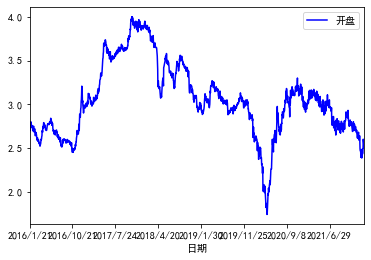

In [3]:
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()
    
draw_ts(pd.DataFrame(national_debt['开盘']))

数据预处理

In [4]:
# 前(1563-600=1263)天的开盘价作为训练集,表格从0开始计数，,0:1 是提取[0:1)列，前闭后开
training_set = national_debt.iloc[0:1563 - 600,0:].values  

#中间300天的数据作为验证集
valid_set= national_debt.iloc[1563 - 600:1563 - 300, 0:].values  

# 后300天的开盘价作为测试集
test_set = national_debt.iloc[1563 - 300:1563, 0:].values  

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
valid_set = sc.transform(valid_set)
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

#对开盘价数据进行归一化，方便后续可视化展示
sc_for_visual = MinMaxScaler(feature_range=(0, 1))  
y_test_for_visual_scaled = sc_for_visual.fit_transform(national_debt.iloc[0:1563 - 600, 0:1].values ) 
y_test_for_visual = sc_for_visual.transform(national_debt.iloc[1563 - 300:1563, 0:1].values )

得到训练集和测试集的数据

In [5]:
x_train = []
y_train = []

x_valid = []
y_valid = []

x_test = []
y_test = []

# 利用for循环，遍历整个训练集，提取训练集中连续10天的开盘价作为输入特征x_train，第11天的数据作为标签
for i in range(5, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 5:i, 1:]) 
    y_train.append(training_set_scaled[i, 0])


# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 5,5))
print(x_train)

#验证集
for i in range(5, len(valid_set)):
    x_valid.append(valid_set[i - 5:i,1:])
    y_valid.append(valid_set[i, 0])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], 5,5))


# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续10天的开盘价作为输入特征x_train，
# 第11天的数据作为标签，for循环共构建300-10=290组数据。
for i in range(5, len(test_set)):
    x_test.append(test_set[i - 5:i,1:])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合CNN和RNN输入要求：
#RNN: [送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],5,5))

[[[0.18613607 0.16322581 0.18825782 0.49134615 0.54317549]
  [0.17907574 0.16451613 0.18953414 0.37692308 0.54967502]
  [0.18228498 0.19354839 0.18825782 0.43461538 0.54085422]
  [0.21052632 0.18709677 0.19463944 0.57307692 0.53528319]
  [0.23363286 0.21483871 0.24122527 0.54230769 0.53435469]]

 [[0.17907574 0.16451613 0.18953414 0.37692308 0.54967502]
  [0.18228498 0.19354839 0.18825782 0.43461538 0.54085422]
  [0.21052632 0.18709677 0.19463944 0.57307692 0.53528319]
  [0.23363286 0.21483871 0.24122527 0.54230769 0.53435469]
  [0.24775353 0.22322581 0.24569241 0.49230769 0.53296193]]

 [[0.18228498 0.19354839 0.18825782 0.43461538 0.54085422]
  [0.21052632 0.18709677 0.19463944 0.57307692 0.53528319]
  [0.23363286 0.21483871 0.24122527 0.54230769 0.53435469]
  [0.24775353 0.22322581 0.24569241 0.49230769 0.53296193]
  [0.24326059 0.22580645 0.25654116 0.39230769 0.53156917]]

 ...

 [[0.3491656  0.3316129  0.35992342 0.41634615 0.79897864]
  [0.35301669 0.32903226 0.35609445 0.435576

训练模型

In [7]:
import os
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5), name="input")

conv_1 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs)

inputs_pool_1 = layers.MaxPooling1D(pool_size = 3)(inputs)
inputs_conv1_3 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs)
inputs_conv1_5 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs)

conv_pool_1 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(tf.convert_to_tensor(inputs_pool_1))
BatchNormalization() 
Activation('relu') 

conv1_3 = layers.Conv1D(filters=64, kernel_size=3,activation='relu', strides=1)(inputs_conv1_3)
BatchNormalization() 
Activation('relu') 

conv1_5 = layers.Conv1D(filters=64, kernel_size=5,activation='relu', strides=1)(inputs_conv1_5)
BatchNormalization()
Activation('relu')  

cnn_output = tf.concat([conv_1,conv_pool_1,conv1_3,conv1_5], 1)
x = layers.Flatten()(cnn_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(60)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs, outputs, name="outputs")
model.summary()

Model: "outputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 5, 5)]       0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 5)         0           input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 64)        384         input[0][0]                      
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 5, 64)        384         input[0][0]                      
____________________________________________________________________________________________

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差

checkpoint_save_path = "./checkpoint/CNN/CNN_nation_debt.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

# print(model.trainable_variables)
file = open('./data/weights_of_nation_debt_by_cnn.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

Epoch 1/100
30/30 [==============================] - 0s 14ms/step - loss: 0.0491 - val_loss: 0.0105
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0139
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0137
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0145
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0148
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0163
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0170
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0163
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0164
Epoch 11

Epoch 83/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 84/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 85/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 86/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 87/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 88/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0086
Epoch 89/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 90/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0060
Epoch 91/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0064


18

11

4033

16

6

756

18

11

4030

16

6

771

16

11

4034

14

6

771

18

11

4031

16

6

772

18

12

1517

16

6

780

18

12

2524

16

6

771

15

11

491

13

7

1525

17

10

490

15

6

730

17

8

901

15

5

13

Text(0.5, 1.0, 'Training and Validation Loss')

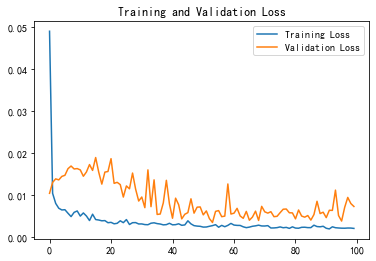

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss') #验证集用来选则最佳的超参数的值
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'national debt Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'national debt Price')

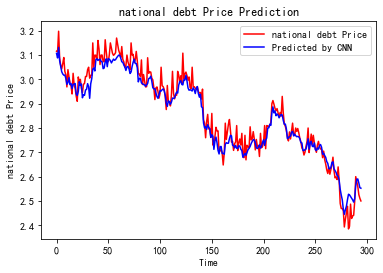

均方误差: 0.001579
均方根误差: 0.039743
平均绝对误差: 0.028925


In [10]:
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)

# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc_for_visual.inverse_transform(predicted_stock_price)

# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc_for_visual.inverse_transform(y_test_for_visual[5:])
# 画出真实数据和预测数据的对比曲线
# 画出真实数据和预测数据的对比曲线
plt.figure(facecolor='white')
plt.plot(real_stock_price, color='red', label='national debt Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted by CNN')
plt.title('national debt Price Prediction')
plt.xlabel('Time')
plt.ylabel('national debt Price')
plt.legend(loc='best')
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

In [11]:
from sklearn.metrics import explained_variance_score
import seaborn as sns

cm = explained_variance_score(real_stock_price, predicted_stock_price)

print(cm )

0.959496842678786


# 将数据用于分类

In [2]:
national_debt = pd.read_csv('data/shibor_nation_debt.csv',index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt.head()
national_debt.describe()

national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()

,开盘,收盘,高,低,涨跌幅,on
日期,,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.78%,2.014
2016/1/22,2.705,2.689,2.705,2.682,-0.41%,2.028
2016/1/25,2.750,2.694,2.750,2.680,0.19%,2.009
2016/1/26,2.703,2.738,2.740,2.690,1.63%,1.997
2016/1/27,2.763,2.774,2.783,2.763,1.31%,1.995


,开盘,收盘,高,低,on
count,1563.000000,1563.000000,1563.000000,1563.000000,1563.000000
mean,3.041862,3.022280,3.049060,3.010074,2.157164
std,0.419688,0.420101,0.418939,0.420670,0.478818
min,1.740000,1.740000,1.740000,1.740000,0.602000
25%,2.746000,2.712000,2.750000,2.697000,1.946000
50%,3.012000,2.993000,3.018000,2.983000,2.172000
75%,3.261000,3.234000,3.269000,3.219000,2.559800
max,4.000000,3.968000,4.000000,3.952000,3.282000


,开盘,收盘,高,低,涨跌幅,on
日期,,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078,2.014
2016/1/22,2.705,2.689,2.705,2.682,-0.0041,2.028
2016/1/25,2.750,2.694,2.750,2.680,0.0019,2.009
2016/1/26,2.703,2.738,2.740,2.690,0.0163,1.997
2016/1/27,2.763,2.774,2.783,2.763,0.0131,1.995


数据可以根据开盘价的涨跌来进行分类，分为涨(1)和跌(0)，然后进行有监督的分类预测

In [3]:
national_debt['is_up'] = 0

for index,value in enumerate(national_debt['开盘']):
    if (index > 0 and value > national_debt['开盘'][index - 1]):
        national_debt['is_up'][index] = 1
           
print(national_debt)
national_debt = national_debt[['is_up', '收盘', '高', '低', '涨跌幅', 'on']]
national_debt

              开盘     收盘      高      低     涨跌幅     on  is_up
日期                                                         
2016/1/21  2.683  2.700  2.703  2.680  0.0078  2.014      0
2016/1/22  2.705  2.689  2.705  2.682 -0.0041  2.028      1
2016/1/25  2.750  2.694  2.750  2.680  0.0019  2.009      1
2016/1/26  2.703  2.738  2.740  2.690  0.0163  1.997      0
...          ...    ...    ...    ...     ...    ...    ...
2022/2/16  2.559  2.500  2.559  2.498 -0.0048  1.942      0
2022/2/17  2.526  2.482  2.526  2.478 -0.0072  1.855      0
2022/2/18  2.511  2.505  2.511  2.479  0.0093  2.110      0
2022/2/21  2.500  2.506  2.520  2.497  0.0000  2.195      0

[1563 rows x 7 columns]


D:\Anaconda3\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,is_up,收盘,高,低,涨跌幅,on
日期,,,,,,
2016/1/21,0,2.700,2.703,2.680,0.0078,2.014
2016/1/22,1,2.689,2.705,2.682,-0.0041,2.028
2016/1/25,1,2.694,2.750,2.680,0.0019,2.009
2016/1/26,0,2.738,2.740,2.690,0.0163,1.997
...,...,...,...,...,...,...
2022/2/16,0,2.500,2.559,2.498,-0.0048,1.942
2022/2/17,0,2.482,2.526,2.478,-0.0072,1.855
2022/2/18,0,2.505,2.511,2.479,0.0093,2.110
2022/2/21,0,2.506,2.520,2.497,0.0000,2.195


In [4]:
#这里归一化的时候不归一化标签列
training_set = national_debt.iloc[1:1563 - 600,0:].values  

valid_set= national_debt.iloc[1563 - 600:1563 - 300, 0:].values  

test_set = national_debt.iloc[1563 - 300:1563, 0:].values  

sc = MinMaxScaler(feature_range=(0, 1)) 
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled[:,0] = training_set[:,0]
valid_set = sc.transform(valid_set)
valid_set[:,0] = valid_set[:,0]
test_set = sc.transform(test_set)  
test_set[:,0] = test_set[:,0]

In [5]:
x_train = []
y_train = []

x_valid = []
y_valid = []

x_test = []
y_test = []

for i in range(5, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 5:i, 1:]) 
    y_train.append(training_set_scaled[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 5,5))
print(x_train)

for i in range(5, len(valid_set)):
    x_valid.append(valid_set[i - 5:i,1:])
    y_valid.append(valid_set[i, 0])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], 5,5))



for i in range(5, len(test_set)):
    x_test.append(test_set[i - 5:i,1:])
    y_test.append(test_set[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],5,5))

print(y_train)

[[[0.17907574 0.16451613 0.18953414 0.37692308 0.54967502]
  [0.18228498 0.19354839 0.18825782 0.43461538 0.54085422]
  [0.21052632 0.18709677 0.19463944 0.57307692 0.53528319]
  [0.23363286 0.21483871 0.24122527 0.54230769 0.53435469]
  [0.24775353 0.22322581 0.24569241 0.49230769 0.53296193]]

 [[0.18228498 0.19354839 0.18825782 0.43461538 0.54085422]
  [0.21052632 0.18709677 0.19463944 0.57307692 0.53528319]
  [0.23363286 0.21483871 0.24122527 0.54230769 0.53435469]
  [0.24775353 0.22322581 0.24569241 0.49230769 0.53296193]
  [0.24326059 0.22580645 0.25654116 0.39230769 0.53156917]]

 [[0.21052632 0.18709677 0.19463944 0.57307692 0.53528319]
  [0.23363286 0.21483871 0.24122527 0.54230769 0.53435469]
  [0.24775353 0.22322581 0.24569241 0.49230769 0.53296193]
  [0.24326059 0.22580645 0.25654116 0.39230769 0.53156917]
  [0.22400513 0.21935484 0.20102106 0.3125     0.53064067]]

 ...

 [[0.3491656  0.3316129  0.35992342 0.41634615 0.79897864]
  [0.35301669 0.32903226 0.35609445 0.435576

In [6]:
import os
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers import Conv1D, MaxPooling1D,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5), name="input")

conv_1 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs)

inputs_pool_1 = layers.MaxPooling1D(pool_size = 3)(inputs)
inputs_conv1_3 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs)
inputs_conv1_5 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs)

conv_pool_1 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(tf.convert_to_tensor(inputs_pool_1))
BatchNormalization() 
Activation('relu') 

conv1_3 = layers.Conv1D(filters=64, kernel_size=3,activation='relu', strides=1)(inputs_conv1_3)
BatchNormalization() 
Activation('relu') 

conv1_5 = layers.Conv1D(filters=64, kernel_size=5,activation='relu', strides=1)(inputs_conv1_5)
BatchNormalization()
Activation('relu')  

cnn_output = tf.concat([conv_1,conv_pool_1,conv1_3,conv1_5], 1)
x = layers.Flatten()(cnn_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(60)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs, outputs, name="outputs")
model.summary()

Model: "outputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 5, 5)]       0                                            
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 5)         0           input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 64)        384         input[0][0]                      
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 5, 64)        384         input[0][0]                      
____________________________________________________________________________________________

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid), validation_freq=1)

model.summary()

Epoch 1/100
30/30 [==============================] - 0s 8ms/step - loss: 0.1337 - sparse_categorical_accuracy: 0.9467 - val_loss: 33.2544 - val_sparse_categorical_accuracy: 0.6271
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9624 - val_loss: 33.3716 - val_sparse_categorical_accuracy: 0.5932
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9436 - val_loss: 34.0469 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9613 - val_loss: 31.5146 - val_sparse_categorical_accuracy: 0.6068
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9582 - val_loss: 31.1022 - val_sparse_categorical_accuracy: 0.5966
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1571 - sparse_categorical

30/30 [==============================] - 0s 3ms/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9791 - val_loss: 30.7160 - val_sparse_categorical_accuracy: 0.6136
Epoch 47/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9634 - val_loss: 31.2142 - val_sparse_categorical_accuracy: 0.6102
Epoch 48/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0765 - sparse_categorical_accuracy: 0.9718 - val_loss: 32.0536 - val_sparse_categorical_accuracy: 0.6203
Epoch 49/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0821 - sparse_categorical_accuracy: 0.9707 - val_loss: 31.8068 - val_sparse_categorical_accuracy: 0.6203
Epoch 50/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9676 - val_loss: 34.4296 - val_sparse_categorical_accuracy: 0.6203
Epoch 51/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0683 - sparse_categorical_accura

30/30 [==============================] - 0s 3ms/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9655 - val_loss: 30.9408 - val_sparse_categorical_accuracy: 0.6102
Epoch 92/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0813 - sparse_categorical_accuracy: 0.9707 - val_loss: 29.8977 - val_sparse_categorical_accuracy: 0.5932
Epoch 93/100
30/30 [==============================] - 0s 3ms/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9603 - val_loss: 28.9873 - val_sparse_categorical_accuracy: 0.6000
Epoch 94/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9687 - val_loss: 29.3081 - val_sparse_categorical_accuracy: 0.6034
Epoch 95/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9781 - val_loss: 30.3264 - val_sparse_categorical_accuracy: 0.6169
Epoch 96/100
30/30 [==============================] - 0s 3ms/step - loss: 0.0678 - sparse_categorical_accura

Text(0.5, 1.0, 'Training and Validation Accuracy')

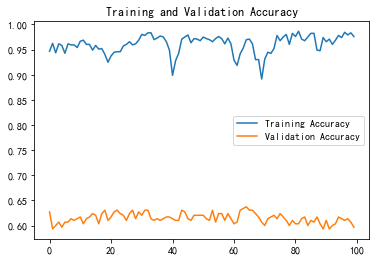

Text(0.5, 1.0, 'Training and Validation Loss')

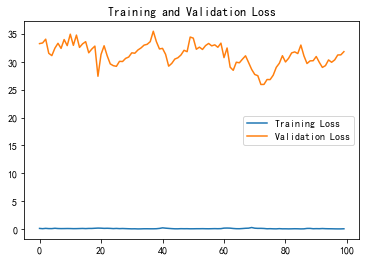

In [49]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix
# 测试集输入模型进行预测
predicted= model.predict(x_test)

predicted_final = []
for item in predicted:
    if (item[0] < item[1]):
        predicted_final.append(1)
    else:
        predicted_final.append(0)
confusion_matrix(y_test, predicted_final)

array([[128,  44],
       [ 51,  72]], dtype=int64)

In [51]:
def cm_plot(y, yp): #编写混淆矩阵可视化函数

    from sklearn.metrics import confusion_matrix #导入混淆矩阵函数

    cm = confusion_matrix(y, yp) #混淆矩阵

    import matplotlib.pyplot as plt #导入作图库
    plt.matshow(cm,interpolation='nearest',cmap=plt.cm.Greens) #画混淆矩阵图，配色风格使用cm.coolwarm,其余可选的有cm.Greens,cm.Paired等
    plt.colorbar() #颜色标签

#     for x in range(len(cm)): #数据标签
#         for y in range(len(cm)):
#             plt.annotate(cm[x,y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
        
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
             plt.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)

    plt.ylabel('True label') #坐标轴标签
    plt.xlabel('Predicted label') #坐标轴标签
#     plt.figure(figsize=(12,6))
    plt.show()

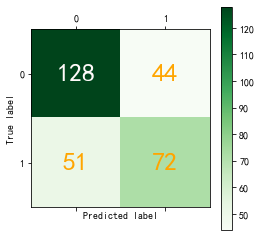

0.6779661016949152


In [52]:
cm_plot(y_test,predicted_final)
from sklearn.metrics import accuracy_score

# 准确率
print(accuracy_score(y_test,predicted_final))

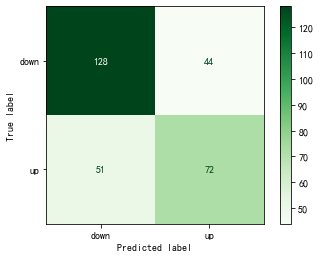

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test,predicted_final) #混淆矩阵
labels=["down", "up"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="Greens",                 
    ax=None,                        
    xticks_rotation="horizontal",   
    values_format="d"               # 显示的数值格式
)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

<Figure size 432x288 with 0 Axes>

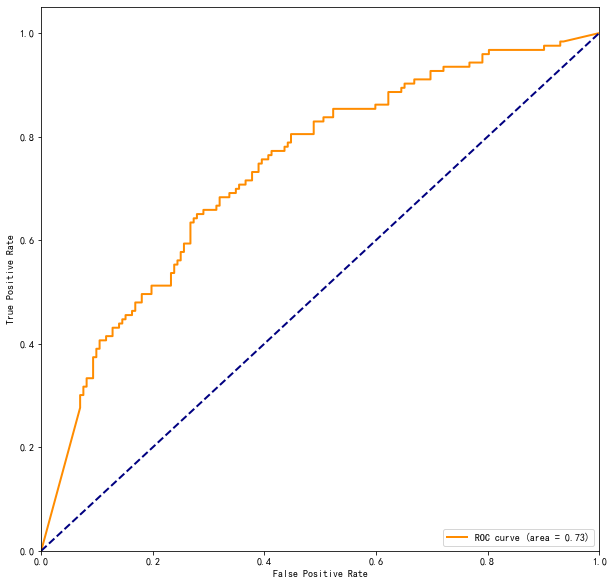

In [54]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
# from sklearn import cross_validation

#把y_test变成softmax
Y_pred_0 = [y[1] for y in predicted]  # 取出y中的一列
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, Y_pred_0) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值
 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
